# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.

Построим модель с значением *accuracy* не менее 0.75.

## Откроем и изучим файл

In [1]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from tqdm import tqdm

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропуски отсутствуют, будем решать задачу классификации с таргетом `is_ultra`, значение 1 в которм означает наличие тарифа "Ультра" (0 - тариф "Смарт").

In [6]:
display(df.corr())

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


In [7]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


## Разобьём данные на выборки

In [8]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [9]:
# Разобьём данные на три выборки, используя стратификацию
features_tav, features_test, target_tav, target_test = train_test_split(features, target, test_size=0.2, random_state=11363, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(features_tav, target_tav, test_size=0.25, random_state=11363, stratify=target_tav)

In [10]:
print(len(features_train)/len(df))
print(len(features_test)/len(df))
print(len(features_valid)/len(df))

0.5998755444928439
0.2000622277535781
0.2000622277535781


In [11]:
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [1337  591]
Количество строк в target_valid по классам: [446 197]
Количество строк в target_test по классам: [446 197]


## Исследуем модели

In [12]:
# В качестве первой модели используем дерево решений c глубиной 1-20
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
train_plot = []
valid_plot = []
ticks = []
for depth in tqdm(range(1, 21)):
    model = DecisionTreeClassifier(random_state=11363, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_train = model.predict(features_train)
    result = accuracy_score(target_train, predictions_train)
    train_plot.append(result)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    valid_plot.append(result)
    ticks.append(depth)
    if result > best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth_tree = depth
print(f'Лучшая модель c глубиной {best_depth_tree} имеет Accuracy: {best_result_tree:.3f}')

100%|██████████| 20/20 [00:00<00:00, 91.89it/s] 

Лучшая модель c глубиной 7 имеет Accuracy: 0.792


CPU times: user 44.8 ms, sys: 74 µs, total: 44.9 ms
Wall time: 53.6 ms


<function matplotlib.pyplot.show(close=None, block=None)>

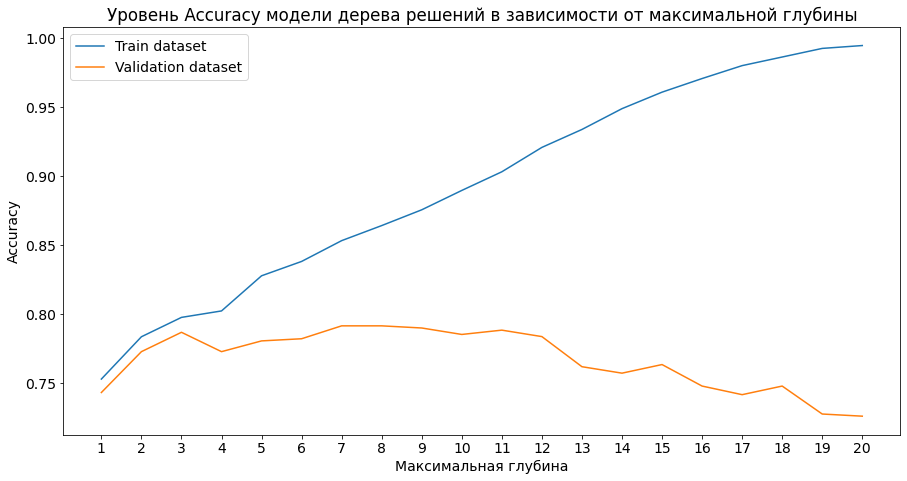

In [13]:
%%time
plt.figure(figsize=(15, 7.5))
plt.plot(ticks, train_plot)
plt.plot(ticks, valid_plot)


plt.title('Уровень Accuracy модели дерева решений в зависимости от максимальной глубины')
plt.xlabel('Максимальная глубина')
plt.ylabel('Accuracy')
plt.legend(['Train dataset', 'Validation dataset'])
plt.xticks(ticks)

plt.show;

График наглядно демонстрирует фактор переобучения модели с ростом максимальной глубины.  
Иными словами: с увеличением максимальной глубины дерева решений, точность предсказания растёт на тренировочных данных, но падает на валидационных.

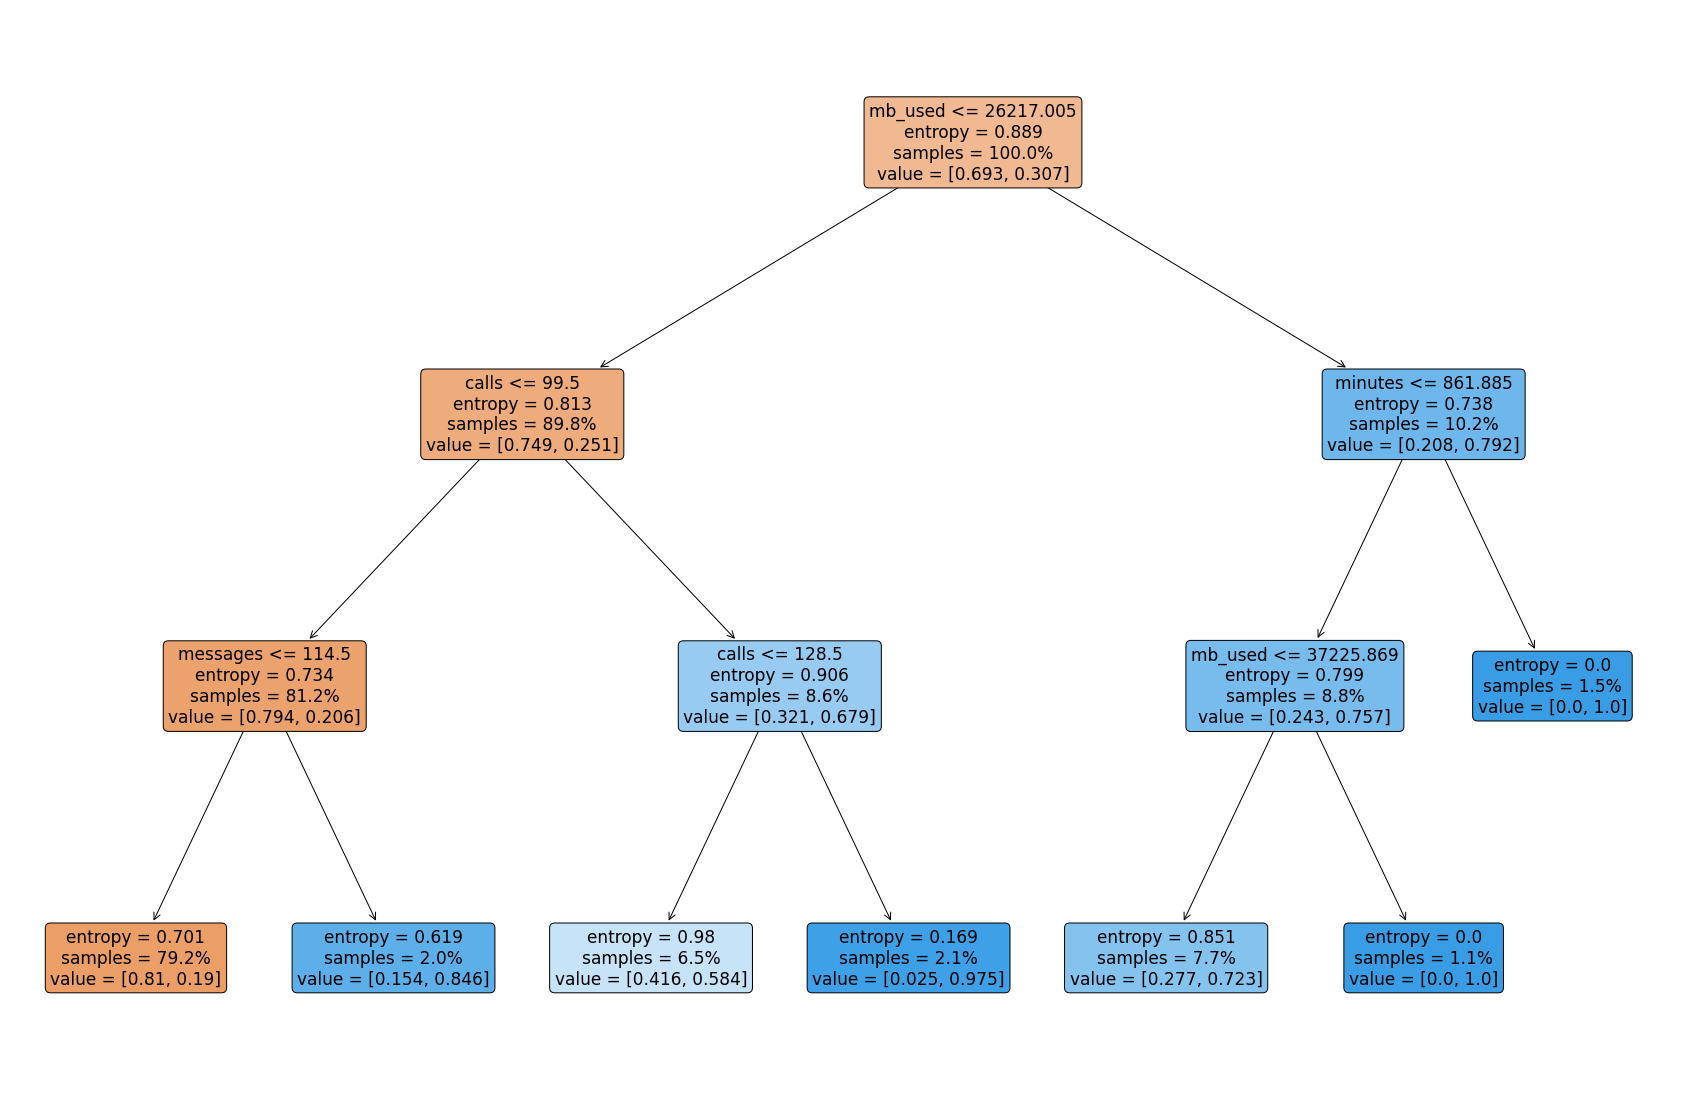

In [14]:
model = DecisionTreeClassifier(random_state=11363, max_depth=3, min_samples_split=2, criterion='entropy')
model.fit(features_train, target_train)
plt.figure(figsize=(30,20))
sklearn.tree.plot_tree(model, feature_names=features_train.columns, filled=True, proportion=True, rounded=True, fontsize=17);

In [22]:
# Применим случайный лес с количеством деревьев 10 - 100 с шагом в 10 и глубиной в диапазоне 1-10
best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est_forest = 0
for est in tqdm(range(10, 101, 10)):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=11363, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result_forest:
            best_model_forest = model
            best_result_forest = result
            best_est_forest = est
            best_depth_forest = depth
print(f'Лучшая модель с количеством деревьев {best_est_forest} и глубиной {best_depth_forest} имеет Accuracy: {best_result_forest:.3f}')


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

Лучшая модель с количеством деревьев 40 и глубиной 9 имеет Accuracy: 0.813


In [16]:
# Применим модель логистической регрессии с перебором количества итерраций и коэффициента регуляризации
best_model_log = None
best_result_log = 0
best_iter_log = 0
best_ck_log = 0
for n_iter in tqdm(range(150, 1001, 50)):
    ck = 1.0
    while ck > 0.1:
        model = LogisticRegression(random_state=36311, solver='lbfgs', max_iter=n_iter, C=ck)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result_log:
            best_model_log = model
            best_result_log = result
            best_iter_log = n_iter
            best_ck_log = ck
        ck -= 0.1
print(f'Лучшая модель логистической регрессии имеет количество итерраций {best_iter_log}, коэффициент регуляризации {best_ck_log} Accuracy: {best_result_log:.3f}')

100%|██████████| 18/18 [00:07<00:00,  2.56it/s]

Лучшая модель логистической регрессии имеет количество итерраций 150, коэффициент регуляризации 1.0 Accuracy: 0.747


**Лучше всего себя показала модель RandomForest с количеством деревьев 40 и глубиной 9, Accuracy ~ 0.813**.

## Проверим модель на тестовой выборке

In [17]:
model = best_model_forest
#model.fit(features_train, target_train) # Здесь же было необходимо ещё раз передать тренировочные данные?
predictions_test = model.predict(features_test)
result_test = accuracy_score(target_test, predictions_test)
print(f'Модель {model} \nвыполняет задачу классификации на тестовой выборке с Accuracy: {result_test:.3f}')

Модель RandomForestClassifier(max_depth=9, n_estimators=40, random_state=11363) 
выполняет задачу классификации на тестовой выборке с Accuracy: 0.820


In [18]:
model = best_model_forest
model.fit(features_tav, target_tav)
predictions_test = model.predict(features_test)
result = accuracy_score(target_test, predictions_test)
print(f'Модель {model}, \nобученная на тренировочных + валидационных данных, \nвыполняет задачу классификации на тестовой выборке с Accuracy: {result_test:.3f}')

Модель RandomForestClassifier(max_depth=9, n_estimators=40, random_state=11363), 
обученная на тренировочных + валидационных данных, 
выполняет задачу классификации на тестовой выборке с Accuracy: 0.820


## Проверим модель на адекватность

In [19]:
# Посмотрим на распределение значений таргета в полном датасете
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [20]:
# Создадим константую модель по метке наибольшего класса и оценим её качество
dummy_clsf = DummyClassifier(strategy='most_frequent')
dummy_clsf.fit(features_test, target_test)
dummy_clsf.predict(features_test)
result_dummy = dummy_clsf.score(features_test, target_test)
print(f'Константная модель имеет Accuracy: {result_dummy:.3f}')

Константная модель имеет Accuracy: 0.694


Константная модель уступает лучшей модели в Accuracy ~ 0.694 против 0.820 на тестовой выборке.

## Вывод:  
В нашем распоряжении распоряжении данные о поведении клиентов, которые уже используют активные тарифы сотового оператора.
С учётом необходимости построения модели классификации для выбора подходящих тарифов, данные были разделены на три выборки (train, validation, test) с учётом стратификации.  

Было протестировано три модели с различным набором гиперпараметров (Decision Tree, Random Forest, Logostic Regression).  
На валидационных данных наилучший уровень Accuracy 0.813 показала модель RF с количеством деревьев 40 и максимальной глубиной 9.  
После чего мы обучили модель на выборке train+validation, показатель Accuracy для тестовой выборки составил 0.820, что превышает Accuracy DummyClassifier'а (0.694).  

**Построенную модель рекомендуется использовать для повышения уровня действующих тарифов (upsale) посредством CRM кампаний.**